## 1. DataSet import

In [38]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Model

In [39]:
# Taken from https://github.com/dylan-slack/manipulating-cfes/blob/main/train_models.py
# wanted to use this the same model as in the paper
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.tanh3(out)
        out = self.fc4(out)
        return out


In [40]:
torch.manual_seed(41)
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [41]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 1001

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train.cpu().detach().numpy(),
        y_pred=y_pred.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test.cpu().detach().numpy(),
            y_pred=test_pred.cpu().detach().numpy())

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%")

Epoch: 0 | Loss: 0.64789, F1-Training: 0.82% | Test loss: 0.62726, F1-Testing: 0.83%
Epoch: 100 | Loss: 0.59639, F1-Training: 0.82% | Test loss: 0.60061, F1-Testing: 0.83%
Epoch: 200 | Loss: 0.57190, F1-Training: 0.82% | Test loss: 0.59534, F1-Testing: 0.83%
Epoch: 300 | Loss: 0.55950, F1-Training: 0.82% | Test loss: 0.58949, F1-Testing: 0.81%
Epoch: 400 | Loss: 0.55054, F1-Training: 0.82% | Test loss: 0.59070, F1-Testing: 0.81%
Epoch: 500 | Loss: 0.54252, F1-Training: 0.83% | Test loss: 0.59373, F1-Testing: 0.82%
Epoch: 600 | Loss: 0.53501, F1-Training: 0.82% | Test loss: 0.59515, F1-Testing: 0.83%
Epoch: 700 | Loss: 0.52896, F1-Training: 0.83% | Test loss: 0.59555, F1-Testing: 0.83%
Epoch: 800 | Loss: 0.52344, F1-Training: 0.83% | Test loss: 0.59565, F1-Testing: 0.83%
Epoch: 900 | Loss: 0.51821, F1-Training: 0.83% | Test loss: 0.59339, F1-Testing: 0.84%
Epoch: 1000 | Loss: 0.51363, F1-Training: 0.83% | Test loss: 0.59174, F1-Testing: 0.85%


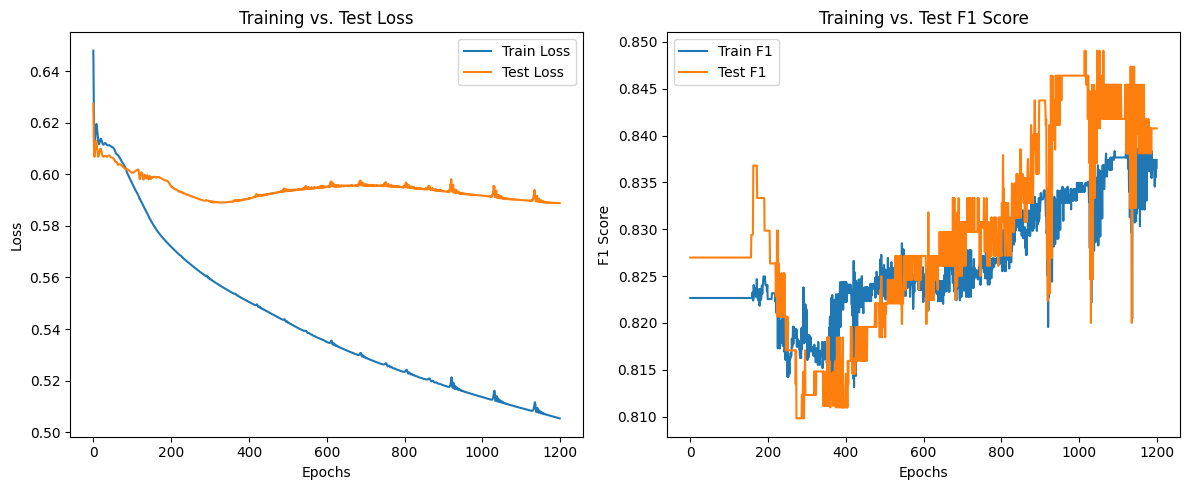

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# plot f1_score
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Counterfactual generation:
### 4.1. of one Instance

In [45]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

In [46]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)  
            return probabilities.cpu().numpy()

dice_model = dice_ml.Model(
    model=PyTorchModelWrapper(model),
    backend="sklearn",
    model_type='classifier'
)

exp = dice_ml.Dice(
    dice_data,
    dice_model,
    method="genetic"
)


In [62]:

query_instance = X[11:12]
query_df = pd.DataFrame(query_instance, columns=feature_names)


#  generate counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=3,
    desired_class="opposite",
    features_to_vary = actionable_features
)

dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Query instance (original outcome : 0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,1.0,0.0,0.0,24.0,48.0,4308.0,3.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,-,-,-,-,24.0,-,-,-,-,-,...,-,-,-,-,-,-,0.0,-,-,1.0
0,-,-,-,-,24.0,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,24.0,-,-,-,-,-,...,-,-,-,1.0,0.0,-,0.0,-,-,1.0


### 4.2. calculating L1 Distance

In [66]:
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
original = X[11:12]
cf_values = cf_df[feature_names].values
cf_tensor = torch.from_numpy(cf_values).float().cpu()
distances = torch.norm(original - cf_tensor, p=1, dim=1)
distance_mean = distances.mean().item()

print("Mean Distance between original and cf values:", distance_mean)


Mean Distance between original and cf values: 230.3333282470703


## 4.3. Calculating the mean value of all L1 Distances of negatively classified instances

In [67]:
from Helper_functions import *

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(model, X)


In [69]:
query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=3,
    desired_class="opposite",
    features_to_vary=actionable_features
)

100%|██████████| 145/145 [08:37<00:00,  3.57s/it]


In [71]:
all_distances = []
for i in range(len(X_negative)):
    original = X_negative[i]
    cf_df = dice_exp.cf_examples_list[i].final_cfs_df

    if cf_df is None or cf_df.empty:
        continue

    cf_values = cf_df[feature_names].values
    cf_tensor = torch.from_numpy(cf_values).float().cpu()
    distances = torch.norm(original - cf_tensor, p=1, dim=1)
    distance_mean = distances.mean().item()
    all_distances.append(distance_mean)

# Compute mean L1 distance
mean_l1 = np.mean(all_distances)
print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")

Mean L1 distance for negatively classified data using DiCE: 2069.40


## 5. Saving the model

In [72]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Calculating the initial approximation of recourse

## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [108]:
lamda = 0.1
epochs = 1000
patience = 100
delta = 0.001
best_f1 = 0.0
counter = 0

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

initial_f1_score = f1_score(y, torch.argmax(loaded_model(X), dim=1))
print(f"Initial f1_score: {initial_f1_score:.2f}")

X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)

for epoch in range(epochs):
    loaded_model.train()
    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)
    abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)

    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)
        test_loss = test_loss_1 - lamda * test_loss_2

        f1_score_test = f1_score(y_test, test_pred)
        pred = torch.argmax(logits, dim=1)
        f1_X = f1_score(y_test, pred)
    # Early stopping check
    if f1_score_test > best_f1 + delta:
        best_f1 = f1_score_test
        counter = 0
        # Optional: Save best model
        torch.save(loaded_model.state_dict(), "models/best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} (best f1_score: {best_f1:.5f})")
            break

    # Refresh classification split
    if epoch % 10 == 0:
        X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
        X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

# Load the best model after training
best_model = NeuralNetwork(X.shape[1], 200, 2)
best_model.load_state_dict(torch.load("best_model.pth"))

Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.45661| Test loss: 0.53253| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.44108| Test loss: 0.55036| f1_score_test: 0.77419
Early stopping at epoch 111 (best f1_score: 0.84039)


<All keys matched successfully>

## Testing for different Lamdas


In [123]:
lambdas = np.linspace(0.01, 1, 100)

f1_scores = []
recourse_Approximations = []
actual_Recourse_Means = []
for lamda in lambdas:
    epochs = 1000
    patience = 100
    delta = 0.001
    best_f1 = 0.0
    counter = 0

    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

    initial_f1_score = f1_score(y, torch.argmax(loaded_model(X), dim=1))
    print(f"Initial f1_score: {initial_f1_score:.2f}")

    X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
    X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        loaded_model.train()
        y_logits = loaded_model(X_train)
        y_pred = torch.argmax(y_logits, dim=1)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluation
        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)
            test_loss = test_loss_1 - lamda * test_loss_2

            f1_score_test = f1_score(y_test, test_pred)

        # Early stopping check
        if f1_score_test > best_f1 + delta:
            best_f1 = f1_score_test
            counter = 0
            # Optional: Save best model
            torch.save(loaded_model.state_dict(), "models/best_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch} (best f1_score: {best_f1:.5f})")
                f1_scores.append(best_f1)
                break

        # Refresh classification split
        if epoch % 10 == 0:
            X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
            X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

        # Logging
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

    # Load the best model after training
    best_model = NeuralNetwork(X.shape[1], 200, 2)
    best_model.load_state_dict(torch.load("models/best_model.pth"))

    X_positive, X_negative, _, _ = split_by_classification(best_model, X)
    X_test_positive, X_test_negative, _, _ = split_by_classification(best_model, X_test)

    y_logits_negative = best_model(X_negative)
    abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
    recourse_Approximation = torch.mean(abs_differences)
    recourse_Approximations.append(recourse_Approximation.item())

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(best_model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(X_test_negative.cpu().numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_distances = []
    for i in range(len(X_test_negative)):
        original = X_test_negative[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float().cpu()
        distances = torch.norm(original - cf_tensor, p=1, dim=1)
        distance_mean = distances.mean().item()
        all_distances.append(distance_mean)

    # Compute mean L1 distance
    mean_l1 = np.mean(all_distances)
    actual_Recourse_Means.append(mean_l1)

    print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")
    print(f"Lambda = {lamda:.3f} | f1_score: {best_f1:.4f} | Mean Recourse Approximations: {mean_l1:.4f}")




Training for lambda = 0.010
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.50789| Test loss: 0.70159| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.50666| Test loss: 0.58683| f1_score_test: 0.83706
Early stopping at epoch 148 (best f1_score: 0.84906)


100%|██████████| 23/23 [01:31<00:00,  4.00s/it]


Mean L1 distance for negatively classified data using DiCE: 1873.57
Lambda = 0.010 | f1_score: 0.8491 | Mean Recourse Approximations: 1873.5652

Training for lambda = 0.020
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.50219| Test loss: 0.68285| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.50185| Test loss: 0.58493| f1_score_test: 0.82508
Early stopping at epoch 119 (best f1_score: 0.84472)


100%|██████████| 19/19 [01:22<00:00,  4.35s/it]


Mean L1 distance for negatively classified data using DiCE: 1401.27
Lambda = 0.020 | f1_score: 0.8447 | Mean Recourse Approximations: 1401.2719

Training for lambda = 0.030
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.49649| Test loss: 0.66408| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.49525| Test loss: 0.58268| f1_score_test: 0.81481
Early stopping at epoch 114 (best f1_score: 0.84472)


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 1620.02
Lambda = 0.030 | f1_score: 0.8447 | Mean Recourse Approximations: 1620.0175

Training for lambda = 0.040
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.49079| Test loss: 0.64531| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.48777| Test loss: 0.57857| f1_score_test: 0.80272
Early stopping at epoch 115 (best f1_score: 0.84472)


100%|██████████| 19/19 [01:21<00:00,  4.31s/it]


Mean L1 distance for negatively classified data using DiCE: 1605.51
Lambda = 0.040 | f1_score: 0.8447 | Mean Recourse Approximations: 1605.5088

Training for lambda = 0.050
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.48510| Test loss: 0.62652| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.48224| Test loss: 0.57008| f1_score_test: 0.80272
Early stopping at epoch 116 (best f1_score: 0.84177)


100%|██████████| 25/25 [02:30<00:00,  6.01s/it]


Mean L1 distance for negatively classified data using DiCE: 1812.40
Lambda = 0.050 | f1_score: 0.8418 | Mean Recourse Approximations: 1812.4000

Training for lambda = 0.060
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.47940| Test loss: 0.60772| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.47387| Test loss: 0.56462| f1_score_test: 0.80546
Early stopping at epoch 109 (best f1_score: 0.84416)


100%|██████████| 33/33 [04:42<00:00,  8.56s/it]


Mean L1 distance for negatively classified data using DiCE: 2746.67
Lambda = 0.060 | f1_score: 0.8442 | Mean Recourse Approximations: 2746.6667

Training for lambda = 0.070
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.47370| Test loss: 0.58892| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.46522| Test loss: 0.55986| f1_score_test: 0.80139
Early stopping at epoch 117 (best f1_score: 0.84039)


100%|██████████| 34/34 [00:36<00:00,  1.06s/it]


Mean L1 distance for negatively classified data using DiCE: 2324.50
Lambda = 0.070 | f1_score: 0.8404 | Mean Recourse Approximations: 2324.5000

Training for lambda = 0.080
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.46800| Test loss: 0.57012| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.45700| Test loss: 0.55872| f1_score_test: 0.77857
Early stopping at epoch 120 (best f1_score: 0.84039)


100%|██████████| 34/34 [01:39<00:00,  2.91s/it]


Mean L1 distance for negatively classified data using DiCE: 2899.44
Lambda = 0.080 | f1_score: 0.8404 | Mean Recourse Approximations: 2899.4412

Training for lambda = 0.090
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.46231| Test loss: 0.55133| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.44768| Test loss: 0.55369| f1_score_test: 0.77857
Early stopping at epoch 118 (best f1_score: 0.83871)


100%|██████████| 31/31 [02:46<00:00,  5.37s/it]


Mean L1 distance for negatively classified data using DiCE: 2730.81
Lambda = 0.090 | f1_score: 0.8387 | Mean Recourse Approximations: 2730.8118

Training for lambda = 0.100
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.45661| Test loss: 0.53253| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.44108| Test loss: 0.55036| f1_score_test: 0.77419
Early stopping at epoch 111 (best f1_score: 0.84039)


100%|██████████| 34/34 [02:22<00:00,  4.19s/it]


Mean L1 distance for negatively classified data using DiCE: 2627.74
Lambda = 0.100 | f1_score: 0.8404 | Mean Recourse Approximations: 2627.7353

Training for lambda = 0.110
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.45091| Test loss: 0.51373| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.45772| Test loss: 0.53731| f1_score_test: 0.79004
Early stopping at epoch 141 (best f1_score: 0.84404)


100%|██████████| 14/14 [01:10<00:00,  5.05s/it]


Mean L1 distance for negatively classified data using DiCE: 2300.61
Lambda = 0.110 | f1_score: 0.8440 | Mean Recourse Approximations: 2300.6072

Training for lambda = 0.120
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.44521| Test loss: 0.49492| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.44127| Test loss: 0.53155| f1_score_test: 0.78261
Early stopping at epoch 106 (best f1_score: 0.83086)


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Mean L1 distance for negatively classified data using DiCE: 4656.67
Lambda = 0.120 | f1_score: 0.8309 | Mean Recourse Approximations: 4656.6667

Training for lambda = 0.130
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.43952| Test loss: 0.47612| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.31178| Test loss: 0.44653| f1_score_test: 0.30409
Early stopping at epoch 168 (best f1_score: 0.83832)


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 3216.05
Lambda = 0.130 | f1_score: 0.8383 | Mean Recourse Approximations: 3216.0476

Training for lambda = 0.140
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.43382| Test loss: 0.45733| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.44234| Test loss: 0.50923| f1_score_test: 0.81150
Early stopping at epoch 125 (best f1_score: 0.84337)


100%|██████████| 9/9 [01:10<00:00,  7.82s/it]


Mean L1 distance for negatively classified data using DiCE: 3955.28
Lambda = 0.140 | f1_score: 0.8434 | Mean Recourse Approximations: 3955.2777

Training for lambda = 0.150
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.42812| Test loss: 0.43853| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.42815| Test loss: 0.53827| f1_score_test: 0.79195
Early stopping at epoch 126 (best f1_score: 0.84084)


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 5749.25
Lambda = 0.150 | f1_score: 0.8408 | Mean Recourse Approximations: 5749.2500

Training for lambda = 0.160
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.42242| Test loss: 0.41973| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.39508| Test loss: 0.47565| f1_score_test: 0.70400
Early stopping at epoch 126 (best f1_score: 0.84337)


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Mean L1 distance for negatively classified data using DiCE: 4135.44
Lambda = 0.160 | f1_score: 0.8434 | Mean Recourse Approximations: 4135.4444

Training for lambda = 0.170
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.41673| Test loss: 0.40092| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.42438| Test loss: 0.41715| f1_score_test: 0.83483
Early stopping at epoch 127 (best f1_score: 0.84084)


100%|██████████| 8/8 [01:10<00:00,  8.75s/it]


Mean L1 distance for negatively classified data using DiCE: 4994.35
Lambda = 0.170 | f1_score: 0.8408 | Mean Recourse Approximations: 4994.3541

Training for lambda = 0.180
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.41103| Test loss: 0.38212| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.36852| Test loss: 0.36444| f1_score_test: 0.81620
Early stopping at epoch 177 (best f1_score: 0.84498)


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Mean L1 distance for negatively classified data using DiCE: 1781.39
Lambda = 0.180 | f1_score: 0.8450 | Mean Recourse Approximations: 1781.3889

Training for lambda = 0.190
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.40533| Test loss: 0.36332| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.34552| Test loss: 0.40162| f1_score_test: 0.84084
Early stopping at epoch 128 (best f1_score: 0.84337)


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Mean L1 distance for negatively classified data using DiCE: 3553.26
Lambda = 0.190 | f1_score: 0.8434 | Mean Recourse Approximations: 3553.2593

Training for lambda = 0.200
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.39963| Test loss: 0.34452| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.35789| Test loss: 0.42378| f1_score_test: 0.83582
Early stopping at epoch 128 (best f1_score: 0.84337)


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Mean L1 distance for negatively classified data using DiCE: 2722.89
Lambda = 0.200 | f1_score: 0.8434 | Mean Recourse Approximations: 2722.8889

Training for lambda = 0.210
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.39394| Test loss: 0.32571| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.25809| Test loss: 0.31114| f1_score_test: 0.83086
Early stopping at epoch 128 (best f1_score: 0.84592)


100%|██████████| 10/10 [02:14<00:00, 13.44s/it]


Mean L1 distance for negatively classified data using DiCE: 2335.12
Lambda = 0.210 | f1_score: 0.8459 | Mean Recourse Approximations: 2335.1166

Training for lambda = 0.220
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.38824| Test loss: 0.30691| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.40957| Test loss: 0.33415| f1_score_test: 0.82540
Early stopping at epoch 128 (best f1_score: 0.84146)


100%|██████████| 13/13 [01:15<00:00,  5.81s/it]


Mean L1 distance for negatively classified data using DiCE: 3585.92
Lambda = 0.220 | f1_score: 0.8415 | Mean Recourse Approximations: 3585.9231

Training for lambda = 0.230
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.38254| Test loss: 0.28811| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.50825| Test loss: 0.46700| f1_score_test: 0.78378
Early stopping at epoch 129 (best f1_score: 0.84084)


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 2793.42
Lambda = 0.230 | f1_score: 0.8408 | Mean Recourse Approximations: 2793.4167

Training for lambda = 0.240
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.37684| Test loss: 0.26931| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.53672| Test loss: 0.49636| f1_score_test: 0.77352
Early stopping at epoch 130 (best f1_score: 0.83582)


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Mean L1 distance for negatively classified data using DiCE: 2594.61
Lambda = 0.240 | f1_score: 0.8358 | Mean Recourse Approximations: 2594.6111

Training for lambda = 0.250
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.37115| Test loss: 0.25050| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.55819| Test loss: 0.60842| f1_score_test: 0.70079
Early stopping at epoch 129 (best f1_score: 0.83832)


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 4184.33
Lambda = 0.250 | f1_score: 0.8383 | Mean Recourse Approximations: 4184.3334

Training for lambda = 0.260
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.36545| Test loss: 0.23170| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.30416| Test loss: 0.34770| f1_score_test: 0.58716
Early stopping at epoch 155 (best f1_score: 0.84404)


100%|██████████| 14/14 [00:14<00:00,  1.01s/it]


Mean L1 distance for negatively classified data using DiCE: 1196.55
Lambda = 0.260 | f1_score: 0.8440 | Mean Recourse Approximations: 1196.5476

Training for lambda = 0.270
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.35975| Test loss: 0.21290| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.11576| Test loss: 0.24198| f1_score_test: 0.59259
Early stopping at epoch 128 (best f1_score: 0.83735)


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 2027.52
Lambda = 0.270 | f1_score: 0.8373 | Mean Recourse Approximations: 2027.5186

Training for lambda = 0.280
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.35405| Test loss: 0.19409| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.40137| Test loss: -0.02719| f1_score_test: 0.33333
Epoch: 200| Train_Loss: 0.43595| Test loss: 0.46029| f1_score_test: 0.72656
Early stopping at epoch 222 (best f1_score: 0.84431)


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 2017.33
Lambda = 0.280 | f1_score: 0.8443 | Mean Recourse Approximations: 2017.3333

Training for lambda = 0.290
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.34836| Test loss: 0.17529| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.59442| Test loss: 0.66711| f1_score_test: 0.63830
Early stopping at epoch 129 (best f1_score: 0.83234)


100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Mean L1 distance for negatively classified data using DiCE: 1326.43
Lambda = 0.290 | f1_score: 0.8323 | Mean Recourse Approximations: 1326.4286

Training for lambda = 0.300
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.34266| Test loss: 0.15649| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.22055| Test loss: 0.34705| f1_score_test: 0.60633
Early stopping at epoch 129 (best f1_score: 0.83483)


100%|██████████| 8/8 [01:10<00:00,  8.79s/it]


Mean L1 distance for negatively classified data using DiCE: 1126.08
Lambda = 0.300 | f1_score: 0.8348 | Mean Recourse Approximations: 1126.0833

Training for lambda = 0.310
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.33696| Test loss: 0.13768| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.23324| Test loss: 0.16185| f1_score_test: 0.79585
Early stopping at epoch 133 (best f1_score: 0.83735)


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 179.19
Lambda = 0.310 | f1_score: 0.8373 | Mean Recourse Approximations: 179.1852

Training for lambda = 0.320
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.33126| Test loss: 0.11888| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.14407| Test loss: 0.05240| f1_score_test: 0.83333
Early stopping at epoch 129 (best f1_score: 0.83582)


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Mean L1 distance for negatively classified data using DiCE: 181.72
Lambda = 0.320 | f1_score: 0.8358 | Mean Recourse Approximations: 181.7222

Training for lambda = 0.330
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.32557| Test loss: 0.10008| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.40912| Test loss: 0.34347| f1_score_test: 0.69076
Epoch: 200| Train_Loss: 0.16293| Test loss: 0.05968| f1_score_test: 0.81661
Early stopping at epoch 229 (best f1_score: 0.84590)


100%|██████████| 36/36 [00:36<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 538.02
Lambda = 0.330 | f1_score: 0.8459 | Mean Recourse Approximations: 538.0185

Training for lambda = 0.340
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.31987| Test loss: 0.08128| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.49323| Test loss: 0.48241| f1_score_test: 0.53922
Early stopping at epoch 130 (best f1_score: 0.83281)


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 278.15
Lambda = 0.340 | f1_score: 0.8328 | Mean Recourse Approximations: 278.1528

Training for lambda = 0.350
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.31417| Test loss: 0.06247| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.46048| Test loss: 0.44250| f1_score_test: 0.57273
Early stopping at epoch 150 (best f1_score: 0.83792)


100%|██████████| 14/14 [00:14<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 535.38
Lambda = 0.350 | f1_score: 0.8379 | Mean Recourse Approximations: 535.3809

Training for lambda = 0.360
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.30847| Test loss: 0.04367| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.46221| Test loss: 0.45749| f1_score_test: 0.55072
Epoch: 200| Train_Loss: -0.30366| Test loss: -0.21541| f1_score_test: 0.59193
Early stopping at epoch 268 (best f1_score: 0.84488)


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 957.51
Lambda = 0.360 | f1_score: 0.8449 | Mean Recourse Approximations: 957.5088

Training for lambda = 0.370
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.30278| Test loss: 0.02487| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.52601| Test loss: 0.46765| f1_score_test: 0.54884
Epoch: 200| Train_Loss: -0.59896| Test loss: -0.39227| f1_score_test: 0.44898
Early stopping at epoch 238 (best f1_score: 0.84211)


100%|██████████| 37/37 [00:37<00:00,  1.01s/it]


Mean L1 distance for negatively classified data using DiCE: 338.61
Lambda = 0.370 | f1_score: 0.8421 | Mean Recourse Approximations: 338.6126

Training for lambda = 0.380
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.29708| Test loss: 0.00607| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.40976| Test loss: 0.35392| f1_score_test: 0.54460
Early stopping at epoch 180 (best f1_score: 0.82866)


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Mean L1 distance for negatively classified data using DiCE: 443.82
Lambda = 0.380 | f1_score: 0.8287 | Mean Recourse Approximations: 443.8167

Training for lambda = 0.390
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.29138| Test loss: -0.01273| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.49609| Test loss: 0.43680| f1_score_test: 0.45685
Epoch: 200| Train_Loss: -0.74731| Test loss: -0.50346| f1_score_test: 0.47761
Early stopping at epoch 240 (best f1_score: 0.84000)


100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


Mean L1 distance for negatively classified data using DiCE: 755.22
Lambda = 0.390 | f1_score: 0.8400 | Mean Recourse Approximations: 755.2195

Training for lambda = 0.400
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.28568| Test loss: -0.03154| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.51850| Test loss: 0.45845| f1_score_test: 0.43299
Epoch: 200| Train_Loss: -0.72118| Test loss: -0.46123| f1_score_test: 0.47761
Early stopping at epoch 240 (best f1_score: 0.84106)


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 881.10
Lambda = 0.400 | f1_score: 0.8411 | Mean Recourse Approximations: 881.1026

Training for lambda = 0.410
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.27999| Test loss: -0.05034| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.40014| Test loss: 0.23597| f1_score_test: 0.66939
Early stopping at epoch 184 (best f1_score: 0.83893)


100%|██████████| 43/43 [00:43<00:00,  1.01s/it]


Mean L1 distance for negatively classified data using DiCE: 601.38
Lambda = 0.410 | f1_score: 0.8389 | Mean Recourse Approximations: 601.3798

Training for lambda = 0.420
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.27429| Test loss: -0.06914| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.25304| Test loss: 0.10020| f1_score_test: 0.65000
Early stopping at epoch 181 (best f1_score: 0.83601)


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


Mean L1 distance for negatively classified data using DiCE: 247.31
Lambda = 0.420 | f1_score: 0.8360 | Mean Recourse Approximations: 247.3111

Training for lambda = 0.430
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.26859| Test loss: -0.08795| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.20678| Test loss: -0.42556| f1_score_test: 0.83333
Epoch: 200| Train_Loss: -0.95636| Test loss: -0.70912| f1_score_test: 0.39130
Early stopping at epoch 231 (best f1_score: 0.84039)


100%|██████████| 34/34 [01:36<00:00,  2.84s/it]


Mean L1 distance for negatively classified data using DiCE: 440.10
Lambda = 0.430 | f1_score: 0.8404 | Mean Recourse Approximations: 440.1029

Training for lambda = 0.440
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.26289| Test loss: -0.10675| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.74400| Test loss: -0.60039| f1_score_test: 0.26744
Early stopping at epoch 151 (best f1_score: 0.75812)


100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Mean L1 distance for negatively classified data using DiCE: 1671.94
Lambda = 0.440 | f1_score: 0.7581 | Mean Recourse Approximations: 1671.9375

Training for lambda = 0.450
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.25720| Test loss: -0.12555| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.94908| Test loss: -0.70502| f1_score_test: 0.40217
Early stopping at epoch 171 (best f1_score: 0.83007)


100%|██████████| 35/35 [00:36<00:00,  1.04s/it]


Mean L1 distance for negatively classified data using DiCE: 638.11
Lambda = 0.450 | f1_score: 0.8301 | Mean Recourse Approximations: 638.1143

Training for lambda = 0.460
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.25150| Test loss: -0.14435| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.53706| Test loss: 0.57693| f1_score_test: 0.27381
Epoch: 200| Train_Loss: -0.46288| Test loss: -0.34264| f1_score_test: 0.71538
Early stopping at epoch 210 (best f1_score: 0.83766)


100%|██████████| 33/33 [00:34<00:00,  1.04s/it]


Mean L1 distance for negatively classified data using DiCE: 519.49
Lambda = 0.460 | f1_score: 0.8377 | Mean Recourse Approximations: 519.4950

Training for lambda = 0.470
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.24580| Test loss: -0.16316| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.17652| Test loss: 0.11984| f1_score_test: 0.58447
Early stopping at epoch 181 (best f1_score: 0.82192)


100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 767.18
Lambda = 0.470 | f1_score: 0.8219 | Mean Recourse Approximations: 767.1837

Training for lambda = 0.480
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.24010| Test loss: -0.18196| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -1.25135| Test loss: -1.11750| f1_score_test: 0.24706
Epoch: 200| Train_Loss: -0.25735| Test loss: -0.31450| f1_score_test: 0.66116
Early stopping at epoch 210 (best f1_score: 0.83934)


100%|██████████| 36/36 [00:36<00:00,  1.02s/it]


Mean L1 distance for negatively classified data using DiCE: 560.09
Lambda = 0.480 | f1_score: 0.8393 | Mean Recourse Approximations: 560.0926

Training for lambda = 0.490
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.23440| Test loss: -0.20076| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -1.26676| Test loss: -1.04902| f1_score_test: 0.23030
Early stopping at epoch 141 (best f1_score: 0.76868)


100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


Mean L1 distance for negatively classified data using DiCE: 1618.51
Lambda = 0.490 | f1_score: 0.7687 | Mean Recourse Approximations: 1618.5111

Training for lambda = 0.500
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.22871| Test loss: -0.21957| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.57102| Test loss: -0.48521| f1_score_test: 0.59821
Epoch: 200| Train_Loss: -1.95234| Test loss: -1.69192| f1_score_test: 0.40212
Early stopping at epoch 240 (best f1_score: 0.80952)


100%|██████████| 47/47 [00:51<00:00,  1.10s/it]


Mean L1 distance for negatively classified data using DiCE: 868.75
Lambda = 0.500 | f1_score: 0.8095 | Mean Recourse Approximations: 868.7518

Training for lambda = 0.510
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.22301| Test loss: -0.23837| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.33316| Test loss: 0.49834| f1_score_test: 0.17500
Early stopping at epoch 150 (best f1_score: 0.81757)


100%|██████████| 45/45 [00:46<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 976.06
Lambda = 0.510 | f1_score: 0.8176 | Mean Recourse Approximations: 976.0593

Training for lambda = 0.520
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.21731| Test loss: -0.25717| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.29981| Test loss: 0.44029| f1_score_test: 0.14194
Early stopping at epoch 150 (best f1_score: 0.80952)


100%|██████████| 47/47 [01:50<00:00,  2.35s/it]


Mean L1 distance for negatively classified data using DiCE: 1086.69
Lambda = 0.520 | f1_score: 0.8095 | Mean Recourse Approximations: 1086.6915

Training for lambda = 0.530
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.21161| Test loss: -0.27597| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.23284| Test loss: 0.38669| f1_score_test: 0.05442
Early stopping at epoch 151 (best f1_score: 0.81481)


100%|██████████| 44/44 [01:45<00:00,  2.40s/it]


Mean L1 distance for negatively classified data using DiCE: 722.34
Lambda = 0.530 | f1_score: 0.8148 | Mean Recourse Approximations: 722.3409

Training for lambda = 0.540
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.20592| Test loss: -0.29478| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.28539| Test loss: 0.43119| f1_score_test: 0.14103
Early stopping at epoch 150 (best f1_score: 0.80420)


100%|██████████| 55/55 [02:59<00:00,  3.27s/it]


Mean L1 distance for negatively classified data using DiCE: 1034.30
Lambda = 0.540 | f1_score: 0.8042 | Mean Recourse Approximations: 1034.3030

Training for lambda = 0.550
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.20022| Test loss: -0.31358| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.14991| Test loss: 0.34438| f1_score_test: 0.08054
Early stopping at epoch 151 (best f1_score: 0.79152)


100%|██████████| 58/58 [01:00<00:00,  1.04s/it]


Mean L1 distance for negatively classified data using DiCE: 1379.67
Lambda = 0.550 | f1_score: 0.7915 | Mean Recourse Approximations: 1379.6724

Training for lambda = 0.560
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.19452| Test loss: -0.33238| f1_score_test: 0.63478
Epoch: 100| Train_Loss: 0.03147| Test loss: 0.21536| f1_score_test: 0.22892
Early stopping at epoch 121 (best f1_score: 0.76364)


100%|██████████| 66/66 [01:08<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 1776.19
Lambda = 0.560 | f1_score: 0.7636 | Mean Recourse Approximations: 1776.1869

Training for lambda = 0.570
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.18882| Test loss: -0.35119| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.02326| Test loss: 0.19071| f1_score_test: 0.23171
Early stopping at epoch 121 (best f1_score: 0.74074)


100%|██████████| 71/71 [01:13<00:00,  1.03s/it]


Mean L1 distance for negatively classified data using DiCE: 1678.82
Lambda = 0.570 | f1_score: 0.7407 | Mean Recourse Approximations: 1678.8169

Training for lambda = 0.580
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.18313| Test loss: -0.36999| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.20765| Test loss: 0.01671| f1_score_test: 0.38043
Early stopping at epoch 121 (best f1_score: 0.72868)


100%|██████████| 83/83 [03:29<00:00,  2.53s/it]


Mean L1 distance for negatively classified data using DiCE: 1610.66
Lambda = 0.580 | f1_score: 0.7287 | Mean Recourse Approximations: 1610.6606

Training for lambda = 0.590
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.17743| Test loss: -0.38879| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.35985| Test loss: -0.11396| f1_score_test: 0.50000
Early stopping at epoch 120 (best f1_score: 0.66116)


100%|██████████| 99/99 [04:40<00:00,  2.83s/it]


Mean L1 distance for negatively classified data using DiCE: 1618.83
Lambda = 0.590 | f1_score: 0.6612 | Mean Recourse Approximations: 1618.8317

Training for lambda = 0.600
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.17173| Test loss: -0.40759| f1_score_test: 0.63478
Epoch: 100| Train_Loss: -0.41759| Test loss: -0.21503| f1_score_test: 0.52941
Early stopping at epoch 121 (best f1_score: 0.64655)


100%|██████████| 109/109 [03:29<00:00,  1.92s/it]


Mean L1 distance for negatively classified data using DiCE: 1598.02
Lambda = 0.600 | f1_score: 0.6466 | Mean Recourse Approximations: 1598.0229

Training for lambda = 0.610
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.16603| Test loss: -0.42640| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [10:20<00:00,  5.59s/it]


Mean L1 distance for negatively classified data using DiCE: 1688.05
Lambda = 0.610 | f1_score: 0.6348 | Mean Recourse Approximations: 1688.0465

Training for lambda = 0.620
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.16034| Test loss: -0.44520| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:07<00:00,  4.39s/it]


Mean L1 distance for negatively classified data using DiCE: 1594.73
Lambda = 0.620 | f1_score: 0.6348 | Mean Recourse Approximations: 1594.7312

Training for lambda = 0.630
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.15464| Test loss: -0.46400| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:09<00:00,  4.41s/it]


Mean L1 distance for negatively classified data using DiCE: 1596.05
Lambda = 0.630 | f1_score: 0.6348 | Mean Recourse Approximations: 1596.0466

Training for lambda = 0.640
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.14894| Test loss: -0.48280| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [09:07<00:00,  4.93s/it]


Mean L1 distance for negatively classified data using DiCE: 1592.55
Lambda = 0.640 | f1_score: 0.6348 | Mean Recourse Approximations: 1592.5450

Training for lambda = 0.650
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.14324| Test loss: -0.50161| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:05<00:00,  3.83s/it]


Mean L1 distance for negatively classified data using DiCE: 1581.55
Lambda = 0.650 | f1_score: 0.6348 | Mean Recourse Approximations: 1581.5465

Training for lambda = 0.660
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.13755| Test loss: -0.52041| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [09:10<00:00,  4.96s/it]


Mean L1 distance for negatively classified data using DiCE: 1584.27
Lambda = 0.660 | f1_score: 0.6348 | Mean Recourse Approximations: 1584.2688

Training for lambda = 0.670
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.13185| Test loss: -0.53921| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:04<00:00,  3.82s/it]


Mean L1 distance for negatively classified data using DiCE: 1627.36
Lambda = 0.670 | f1_score: 0.6348 | Mean Recourse Approximations: 1627.3604

Training for lambda = 0.680
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.12615| Test loss: -0.55802| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:06<00:00,  3.84s/it]


Mean L1 distance for negatively classified data using DiCE: 1696.01
Lambda = 0.680 | f1_score: 0.6348 | Mean Recourse Approximations: 1696.0075

Training for lambda = 0.690
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.12045| Test loss: -0.57682| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:08<00:00,  3.86s/it]


Mean L1 distance for negatively classified data using DiCE: 1624.39
Lambda = 0.690 | f1_score: 0.6348 | Mean Recourse Approximations: 1624.3904

Training for lambda = 0.700
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.11476| Test loss: -0.59562| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:59<00:00,  3.78s/it]


Mean L1 distance for negatively classified data using DiCE: 1700.64
Lambda = 0.700 | f1_score: 0.6348 | Mean Recourse Approximations: 1700.6381

Training for lambda = 0.710
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.10906| Test loss: -0.61442| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:17<00:00,  3.40s/it]


Mean L1 distance for negatively classified data using DiCE: 1598.59
Lambda = 0.710 | f1_score: 0.6348 | Mean Recourse Approximations: 1598.5916

Training for lambda = 0.720
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.10336| Test loss: -0.63323| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:11<00:00,  3.89s/it]


Mean L1 distance for negatively classified data using DiCE: 1661.37
Lambda = 0.720 | f1_score: 0.6348 | Mean Recourse Approximations: 1661.3694

Training for lambda = 0.730
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.09766| Test loss: -0.65203| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:15<00:00,  3.38s/it]


Mean L1 distance for negatively classified data using DiCE: 1591.84
Lambda = 0.730 | f1_score: 0.6348 | Mean Recourse Approximations: 1591.8408

Training for lambda = 0.740
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.09197| Test loss: -0.67083| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:11<00:00,  3.89s/it]


Mean L1 distance for negatively classified data using DiCE: 1617.28
Lambda = 0.740 | f1_score: 0.6348 | Mean Recourse Approximations: 1617.2838

Training for lambda = 0.750
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.08627| Test loss: -0.68964| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:08<00:00,  3.86s/it]


Mean L1 distance for negatively classified data using DiCE: 1548.55
Lambda = 0.750 | f1_score: 0.6348 | Mean Recourse Approximations: 1548.5465

Training for lambda = 0.760
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.08057| Test loss: -0.70844| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:18<00:00,  3.41s/it]


Mean L1 distance for negatively classified data using DiCE: 1681.93
Lambda = 0.760 | f1_score: 0.6348 | Mean Recourse Approximations: 1681.9324

Training for lambda = 0.770
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.07487| Test loss: -0.72724| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [09:00<00:00,  4.87s/it]


Mean L1 distance for negatively classified data using DiCE: 1577.58
Lambda = 0.770 | f1_score: 0.6348 | Mean Recourse Approximations: 1577.5781

Training for lambda = 0.780
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.06918| Test loss: -0.74604| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [09:03<00:00,  4.89s/it]


Mean L1 distance for negatively classified data using DiCE: 1569.99
Lambda = 0.780 | f1_score: 0.6348 | Mean Recourse Approximations: 1569.9925

Training for lambda = 0.790
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.06348| Test loss: -0.76485| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:05<00:00,  4.38s/it]


Mean L1 distance for negatively classified data using DiCE: 1578.09
Lambda = 0.790 | f1_score: 0.6348 | Mean Recourse Approximations: 1578.0886

Training for lambda = 0.800
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.05778| Test loss: -0.78365| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:37<00:00,  3.04s/it]


Mean L1 distance for negatively classified data using DiCE: 1652.46
Lambda = 0.800 | f1_score: 0.6348 | Mean Recourse Approximations: 1652.4640

Training for lambda = 0.810
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.05208| Test loss: -0.80245| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:42<00:00,  4.17s/it]


Mean L1 distance for negatively classified data using DiCE: 1551.56
Lambda = 0.810 | f1_score: 0.6348 | Mean Recourse Approximations: 1551.5571

Training for lambda = 0.820
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.04639| Test loss: -0.82126| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:12<00:00,  3.90s/it]


Mean L1 distance for negatively classified data using DiCE: 1654.31
Lambda = 0.820 | f1_score: 0.6348 | Mean Recourse Approximations: 1654.3123

Training for lambda = 0.830
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.04069| Test loss: -0.84006| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [04:31<00:00,  2.45s/it]


Mean L1 distance for negatively classified data using DiCE: 1595.66
Lambda = 0.830 | f1_score: 0.6348 | Mean Recourse Approximations: 1595.6607

Training for lambda = 0.840
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.03499| Test loss: -0.85886| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:16<00:00,  3.40s/it]


Mean L1 distance for negatively classified data using DiCE: 1467.68
Lambda = 0.840 | f1_score: 0.6348 | Mean Recourse Approximations: 1467.6832

Training for lambda = 0.850
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.02929| Test loss: -0.87766| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:49<00:00,  3.15s/it]


Mean L1 distance for negatively classified data using DiCE: 1743.65
Lambda = 0.850 | f1_score: 0.6348 | Mean Recourse Approximations: 1743.6532

Training for lambda = 0.860
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.02360| Test loss: -0.89647| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:20<00:00,  2.89s/it]


Mean L1 distance for negatively classified data using DiCE: 1639.37
Lambda = 0.860 | f1_score: 0.6348 | Mean Recourse Approximations: 1639.3679

Training for lambda = 0.870
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.01790| Test loss: -0.91527| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:19<00:00,  3.42s/it]


Mean L1 distance for negatively classified data using DiCE: 1599.89
Lambda = 0.870 | f1_score: 0.6348 | Mean Recourse Approximations: 1599.8904

Training for lambda = 0.880
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.01220| Test loss: -0.93407| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:14<00:00,  3.91s/it]


Mean L1 distance for negatively classified data using DiCE: 1583.74
Lambda = 0.880 | f1_score: 0.6348 | Mean Recourse Approximations: 1583.7417

Training for lambda = 0.890
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.00650| Test loss: -0.95288| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:26<00:00,  2.94s/it]


Mean L1 distance for negatively classified data using DiCE: 1559.08
Lambda = 0.890 | f1_score: 0.6348 | Mean Recourse Approximations: 1559.0826

Training for lambda = 0.900
Initial f1_score: 0.84
Epoch: 0| Train_Loss: 0.00081| Test loss: -0.97168| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:15<00:00,  4.46s/it]


Mean L1 distance for negatively classified data using DiCE: 1568.59
Lambda = 0.900 | f1_score: 0.6348 | Mean Recourse Approximations: 1568.5901

Training for lambda = 0.910
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.00489| Test loss: -0.99048| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [07:12<00:00,  3.89s/it]


Mean L1 distance for negatively classified data using DiCE: 1634.23
Lambda = 0.910 | f1_score: 0.6348 | Mean Recourse Approximations: 1634.2282

Training for lambda = 0.920
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.01059| Test loss: -1.00928| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:23<00:00,  2.92s/it]


Mean L1 distance for negatively classified data using DiCE: 1609.96
Lambda = 0.920 | f1_score: 0.6348 | Mean Recourse Approximations: 1609.9640

Training for lambda = 0.930
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.01629| Test loss: -1.02809| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:17<00:00,  3.40s/it]


Mean L1 distance for negatively classified data using DiCE: 1591.56
Lambda = 0.930 | f1_score: 0.6348 | Mean Recourse Approximations: 1591.5586

Training for lambda = 0.940
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.02198| Test loss: -1.04689| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:23<00:00,  2.92s/it]


Mean L1 distance for negatively classified data using DiCE: 1666.97
Lambda = 0.940 | f1_score: 0.6348 | Mean Recourse Approximations: 1666.9715

Training for lambda = 0.950
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.02768| Test loss: -1.06569| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [05:32<00:00,  3.00s/it]


Mean L1 distance for negatively classified data using DiCE: 1631.14
Lambda = 0.950 | f1_score: 0.6348 | Mean Recourse Approximations: 1631.1381

Training for lambda = 0.960
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.03338| Test loss: -1.08449| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:04<00:00,  4.36s/it]


Mean L1 distance for negatively classified data using DiCE: 1610.29
Lambda = 0.960 | f1_score: 0.6348 | Mean Recourse Approximations: 1610.2898

Training for lambda = 0.970
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.03908| Test loss: -1.10330| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:16<00:00,  3.39s/it]


Mean L1 distance for negatively classified data using DiCE: 1681.09
Lambda = 0.970 | f1_score: 0.6348 | Mean Recourse Approximations: 1681.0886

Training for lambda = 0.980
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.04477| Test loss: -1.12210| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:17<00:00,  3.40s/it]


Mean L1 distance for negatively classified data using DiCE: 1667.46
Lambda = 0.980 | f1_score: 0.6348 | Mean Recourse Approximations: 1667.4640

Training for lambda = 0.990
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.05047| Test loss: -1.14090| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [06:17<00:00,  3.40s/it]


Mean L1 distance for negatively classified data using DiCE: 1573.55
Lambda = 0.990 | f1_score: 0.6348 | Mean Recourse Approximations: 1573.5481

Training for lambda = 1.000
Initial f1_score: 0.84
Epoch: 0| Train_Loss: -0.05617| Test loss: -1.15971| f1_score_test: 0.63478
Early stopping at epoch 100 (best f1_score: 0.63478)


100%|██████████| 111/111 [08:05<00:00,  4.38s/it]

Mean L1 distance for negatively classified data using DiCE: 1645.14
Lambda = 1.000 | f1_score: 0.6348 | Mean Recourse Approximations: 1645.1351


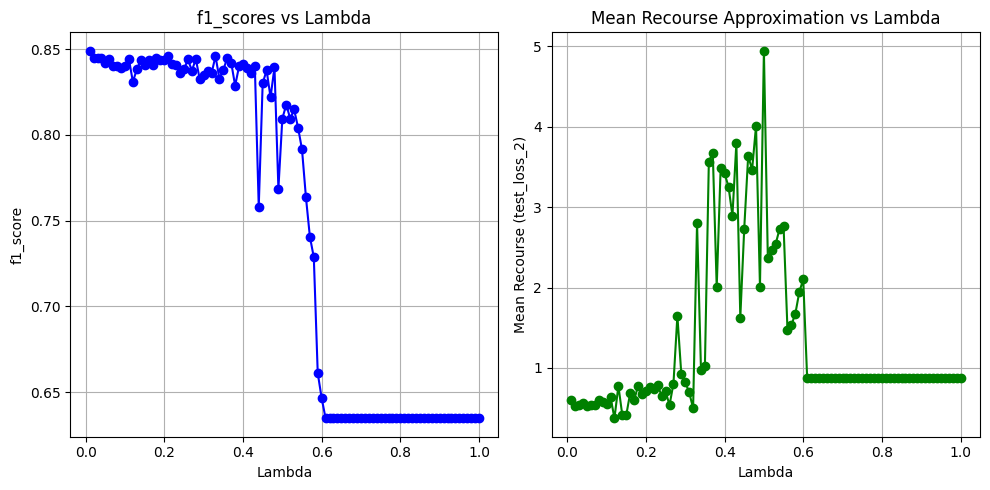

In [124]:
plt.figure(figsize=(10, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lambdas, f1_scores, marker='o', color='blue')
plt.title("f1_scores vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("f1_score")
plt.grid(True)

# Recourse loss plot
plt.subplot(1, 2, 2)
plt.plot(lambdas, recourse_Approximations, marker='o', color='green')
plt.title("Mean Recourse Approximation vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse (test_loss_2)")
plt.grid(True)

plt.tight_layout()
plt.show()


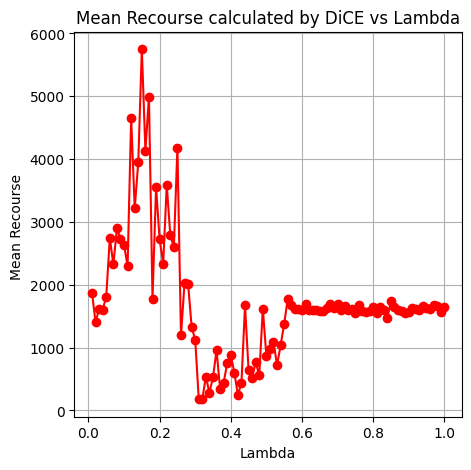

In [125]:
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, actual_Recourse_Means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

i think for lambda = 0.1 the results are ideal . for this lambda the mean recourse loss is 4.0515. here the recouse has doubled around 2.7 times which is a high improvement. But the accuracy took a hard hit sitting around which is not ideal Mean Accuracy: 0.7007

Why cant we use the actual recourse in the training .
Because the recourse given by dice is not differentiable.